In [1]:
import os
import ast
import glob
import pandas as pd
import numpy as np
import seaborn as sns
import cv2
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
writers_info = pd.read_csv('./Data/writers-info.csv')
selected_lang = ['German', 'French']
writers_info = writers_info.loc[writers_info['NativeLanguage'].isin(selected_lang)]
# display(writers_info)
writers_name_list = writers_info['name']
images_path = writers_info['images_path']

width_list = []
height_list = []
for name, i  in zip(writers_name_list, images_path):
  print(name)
  i = ast.literal_eval(i)
  for j in i:
    # print(j)
    image_list = glob.glob(j)
    for k in image_list:
      # print(k)
      # img = cv2.imread(k)
      with Image.open(k) as img:
        img = img.size
        width_list.append(img[0])
        height_list.append(img[1])
      # width_list.append(img.shape[1])
      # height_list.append(img.shape[0])
    # print(image_list)

print(width_list)
print(height_list)
print(len(width_list))
print(len(height_list))

10000
10004
10007
10008
10009
10010
10011
10012
10015
10017
10018
10019
10020
10021
10024
10032
10052
10062
10081
10089
10095
10097
10104
10108
10109
10125
10159
10164
10165
10177
10201
10204
10206
10219
10220
[2161, 2028, 1726, 1769, 2200, 2050, 1560, 803, 813, 892, 600, 782, 1797, 1856, 1780, 1828, 1790, 1551, 1666, 1386, 1614, 1659, 1878, 1865, 1664, 1873, 1860, 1909, 1735, 1779, 1911, 1646, 1904, 578, 1921, 1987, 1992, 1813, 1851, 1900, 1717, 1985, 1960, 1907, 1711, 1708, 1770, 1870, 1758, 1919, 1812, 1795, 1880, 1883, 1766, 461, 1956, 1973, 1767, 1762, 1762, 1941, 1820, 1911, 1962, 1863, 1583, 1821, 1968, 1831, 1736, 1913, 1897, 1883, 1725, 1891, 1584, 1982, 1642, 1250, 1828, 1678, 1676, 1859, 1906, 1867, 1707, 1805, 1725, 1719, 1643, 1624, 1794, 1454, 1305, 1577, 1622, 1522, 1937, 1884, 1819, 1749, 349, 1935, 1961, 1971, 1942, 1841, 1911, 1927, 1752, 1792, 1904, 881, 1609, 1726, 1832, 1672, 1827, 1815, 2011, 1366, 1199, 1818, 1581, 1720, 1242, 1957, 1914, 1899, 1796, 2015, 2000, 

Max Width: 2243
Mean Width: 1745.0
Median Width: 1819.0
98th Percentile Width: 2153.0
Max Height: 1377
Mean Height: 333.0
Median Height: 367.0
98th Percentile Height: 497.0
Selected Width: 2240, Height: 512


<Axes: ylabel='Count'>

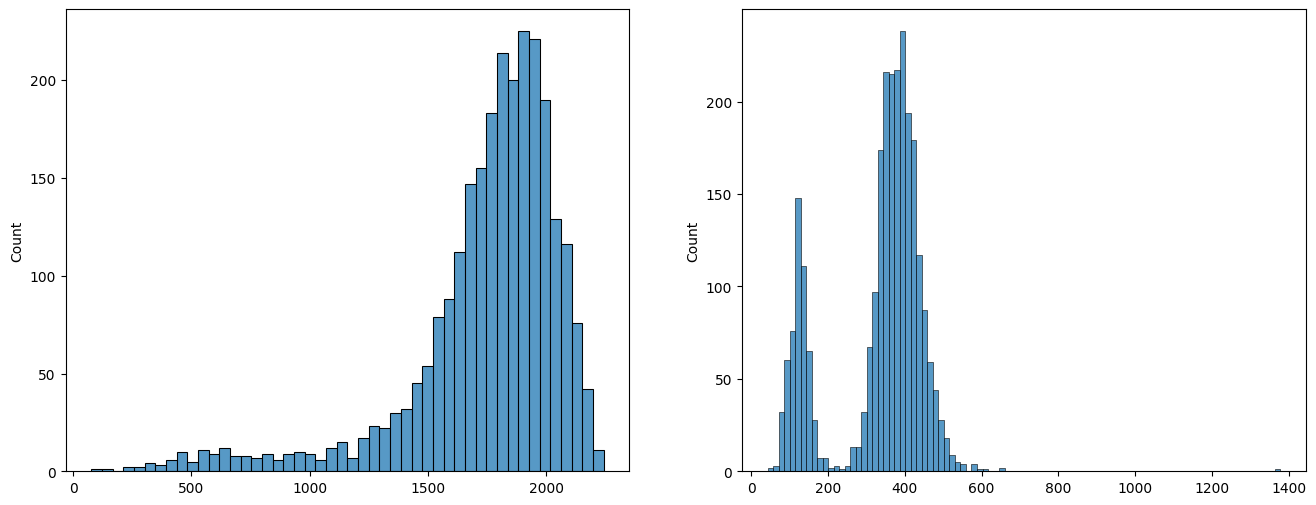

In [3]:
fig, ax = plt.subplots(1,2, figsize = (16,6))

print(f'Max Width: {np.max(width_list)}')
print(f'Mean Width: {np.mean(width_list).round(0)}')
print(f'Median Width: {np.median(width_list).round(0)}')
print(f'98th Percentile Width: {np.percentile(width_list, 98).round(0)}')

print(f'Max Height: {np.max(height_list)}')
print(f'Mean Height: {np.mean(height_list).round(0)}')
print(f'Median Height: {np.median(height_list).round(0)}')
print(f'98th Percentile Height: {np.percentile(height_list, 98).round(0)}')

print('Selected Width: 2240, Height: 512')
sns.histplot(x=width_list,ax=ax[0])
sns.histplot(x=height_list,ax=ax[1])

## Change This (EfficientNetB0) to ViT or SwinModel

In [4]:
from transformers import AutoImageProcessor, ConvNextV2Model
from tensorflow.keras.layers import Input
from tensorflow.keras.preprocessing import image as keras_image
from tensorflow.keras.applications.efficientnet import preprocess_input

model_name = []

model = 'facebook/convnextv2-tiny-22k-384'
processor = AutoImageProcessor.from_pretrained(model)
model = ConvNextV2Model.from_pretrained(model)

all_features_data = []
writer_id_list = []
writer_forms_list = []
for name, i in zip(writers_name_list,images_path):
  i = ast.literal_eval(i)
  for j in i:
    # print(j)
    image_list = glob.glob(j)
    for k in image_list:
      # print(k)
      # img = cv2.imread(k)
      with Image.open(k) as img:
        img = img.convert('RGB')
        original_width, original_height = img.size
        # print(original_width)
        new_width = int(original_width * (512 / original_height))
        # print(new_width)
        resized_img = img.resize((new_width, 512), Image.Resampling.LANCZOS)
        
        if resized_img.width > 2160:
            # THE OUTLIER CASE: If the resized image is still too wide,
            # we perform a second resize to SQUASH it to fit.
            final_img = resized_img.resize((2160, 512), Image.Resampling.LANCZOS)
        else:
            # THE NORMAL CASE: If the image fits,
            # create a blank white canvas and paste the image onto it.
            final_img = Image.new('RGB', (2160, 512), 'white')
            final_img.paste(resized_img, (0, 0))
      
        inputs = processor(images=final_img, return_tensors='pt')
        
        outputs = model(**inputs)
        features = outputs.pooler_output.detach().numpy()
        # last_hidden_states = outputs.last_hidden_state
        # print(last_hidden_states.shape)
        # features = last_hidden_states[:, 0, :]
        # print(features)
        # Store the results
        image_form = os.path.splitext(os.path.basename(k))[0]
        writer_forms_list.append(image_form)
        writer_id_list.append(name)
        all_features_data.append(features.flatten().tolist())
        # save_path = k.find('Data')
        # save_path = k[:7] + 'Formatted-Data/' + k[7:]
        # dir_path = os.path.dirname(save_path)
        # os.makedirs(dir_path, exist_ok=True)
        # # print(save_path, 'TIF')
        # final_img.save(save_path)

writer_features_df = pd.DataFrame(data=all_features_data)
writer_features_df['name'] = writer_id_list
writer_features_df['form'] = writer_forms_list
# writer_features_df = pd.DataFrame(writer_features_df[2].tolist(),index=writer_features_df[0])
# print(all_features_data)
writer_features_df

/Users/veeranonthuvasin/Desktop/MSc-Data-Science-Bristol/Dissertation/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


,0,1,2,3,4,5,6,7,8,9,...,760,761,762,763,764,765,766,767,name,form
0,-0.571697,1.261460,-0.896962,-2.045485,-0.657558,0.688311,0.872243,0.098738,-2.745424,-0.629436,...,0.073616,0.355277,-1.274841,0.215828,-0.210847,1.906537,1.892051,0.716024,10000,z01-000-03
1,-0.617401,1.683710,-0.370848,-1.771416,-0.377822,0.695021,1.095721,0.229832,-2.860271,-0.851637,...,0.468921,-0.202906,-1.045198,0.225852,-0.187759,1.526179,1.526659,0.196687,10000,z01-000-02
2,-0.448969,1.685365,-0.494149,-1.598047,-0.663917,0.730870,0.561499,0.177013,-2.670420,-0.694397,...,0.045399,-0.483041,-1.045340,0.304602,-0.192579,1.245093,1.194240,0.507740,10000,z01-000-01
3,-0.686448,1.668089,-0.316621,-2.181799,-0.858133,0.753625,1.079461,0.280941,-2.786654,-0.295809,...,0.339464,-0.205931,-0.935900,0.188087,-0.305182,1.241609,1.134542,0.068986,10000,z01-000-05
4,-0.675996,1.205480,-0.980199,-2.511955,-0.411895,0.513013,1.161943,0.316724,-3.077692,-0.523500,...,0.232323,0.186722,-1.190333,0.255973,-0.101695,1.327156,1.257383,0.397528,10000,z01-000-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2578,-0.851204,1.772579,-0.339566,-2.171310,-1.370676,0.408270,0.143344,0.063972,-1.841539,-0.459425,...,-0.228844,0.145350,-0.929089,0.681607,-0.464654,1.364797,1.459228,0.645048,10220,r09-711z-01
2579,-0.997527,0.565793,-0.164430,-1.997548,-0.772364,0.746590,0.258118,-0.040935,-2.194748,0.005941,...,-0.507745,-0.228313,-0.765564,0.152436,-0.693647,1.909404,2.179794,0.659266,10220,r09-711z-05
2580,-0.535618,1.022329,-0.488236,-1.811373,-1.018522,0.691729,0.448730,-0.084652,-2.315323,-0.463091,...,-0.186937,-0.095367,-0.965840,0.375361,-0.355476,1.562921,1.856481,0.555189,10220,r09-711z-04
2581,-0.542497,0.774787,-0.923842,-2.091343,-0.822547,0.356091,0.424894,0.072178,-2.449055,-0.557856,...,-0.254058,-0.045749,-1.156777,0.583077,-0.129757,1.490528,1.926554,1.005996,10220,r09-711z-06


In [5]:
writer_features_df.to_csv('./writer_features_df_updated_french_german_ConvNeXtV2.csv')


In [6]:
writer_features_df

writer_group_test = writer_features_df.groupby('name')[writer_features_df.columns[:-1]].agg(['mean','std'])
writer_group_test.columns = writer_group_test.columns.map(lambda x: '|'.join(map(str, x)))
writer_group_test

,0|mean,0|std,1|mean,1|std,2|mean,2|std,3|mean,3|std,4|mean,4|std,...,764|mean,764|std,765|mean,765|std,766|mean,766|std,767|mean,767|std,name|mean,name|std
name,,,,,,,,,,,,,,,,,,,,,
10000,-0.470757,0.189049,1.699413,0.338440,-0.224565,0.505689,-1.706684,0.616108,-0.726862,0.250390,...,-0.334098,0.223373,1.452440,0.229580,1.301115,0.322759,0.212060,0.345890,10000.0,0.0
10004,-0.878848,0.352955,0.544866,0.714501,-0.720909,0.577211,-2.173683,0.628408,-0.434018,0.610542,...,-0.463886,0.236431,1.266248,0.491298,1.322939,0.760476,0.856123,0.311928,10004.0,0.0
10007,-0.612247,0.293455,0.973429,0.466973,-0.738974,0.729919,-1.996205,0.703257,-0.633232,0.452700,...,-0.387980,0.251408,1.271903,0.499715,1.648168,0.400056,0.677284,0.350817,10007.0,0.0
10008,-0.708594,0.325109,0.817444,0.741776,-0.717134,0.612069,-2.130401,0.825668,-0.633252,0.420044,...,-0.488385,0.202610,1.255537,0.380699,1.376305,0.516479,0.751315,0.254943,10008.0,0.0
10009,-0.801645,0.371229,0.880554,0.801910,-0.256733,0.453778,-1.706984,0.678515,-0.415408,0.663905,...,-0.385013,0.206809,1.282281,0.598024,0.709952,0.855841,0.657356,0.422837,10009.0,0.0
10010,-0.648902,0.450934,1.195216,0.604783,-0.675417,0.643575,-2.081466,0.781379,-0.721637,0.498347,...,-0.393668,0.202886,1.149885,0.546047,1.048936,0.590865,0.728278,0.294608,10010.0,0.0
10011,-0.894139,0.416244,0.535562,0.909490,-0.163587,0.386352,-2.146400,0.728521,-0.543088,0.601564,...,-0.536180,0.216998,1.242648,0.495476,1.120316,0.636684,0.749458,0.565225,10011.0,0.0
10012,-0.768736,0.407075,0.689020,1.115823,-0.615376,0.607595,-2.109553,0.822351,-0.710456,0.488397,...,-0.357446,0.242916,1.309858,0.460696,1.295067,0.380751,0.620163,0.298473,10012.0,0.0
10015,-0.739908,0.441423,1.030071,0.758958,-0.527355,0.562485,-2.120274,0.902410,-0.917410,0.379527,...,-0.336924,0.254122,1.301669,0.377128,0.947507,0.423433,0.344268,0.365107,10015.0,0.0


In [7]:
full_writer_features_df = pd.merge(writers_info[['name','Gender','NativeLanguage','WritingType']], writer_group_test.iloc[: ,:-2], how='inner', left_on='name', right_index=True)

full_writer_features_df

,name,Gender,NativeLanguage,WritingType,0|mean,0|std,1|mean,1|std,2|mean,2|std,...,763|mean,763|std,764|mean,764|std,765|mean,765|std,766|mean,766|std,767|mean,767|std
0,10000,Male,German,Right-handed,-0.470757,0.189049,1.699413,0.338440,-0.224565,0.505689,...,0.143204,0.161367,-0.334098,0.223373,1.452440,0.229580,1.301115,0.322759,0.212060,0.345890
1,10004,Male,French,Right-handed,-0.878848,0.352955,0.544866,0.714501,-0.720909,0.577211,...,-0.046882,0.676105,-0.463886,0.236431,1.266248,0.491298,1.322939,0.760476,0.856123,0.311928
4,10007,Male,French,Right-handed,-0.612247,0.293455,0.973429,0.466973,-0.738974,0.729919,...,0.252265,0.342678,-0.387980,0.251408,1.271903,0.499715,1.648168,0.400056,0.677284,0.350817
5,10008,Male,French,Right-handed,-0.708594,0.325109,0.817444,0.741776,-0.717134,0.612069,...,0.105724,0.514173,-0.488385,0.202610,1.255537,0.380699,1.376305,0.516479,0.751315,0.254943
6,10009,Male,German,Right-handed,-0.801645,0.371229,0.880554,0.801910,-0.256733,0.453778,...,-0.111204,0.870960,-0.385013,0.206809,1.282281,0.598024,0.709952,0.855841,0.657356,0.422837
7,10010,Male,French,Right-handed,-0.648902,0.450934,1.195216,0.604783,-0.675417,0.643575,...,0.170764,0.518109,-0.393668,0.202886,1.149885,0.546047,1.048936,0.590865,0.728278,0.294608
8,10011,Male,French,Right-handed,-0.894139,0.416244,0.535562,0.909490,-0.163587,0.386352,...,-0.270729,0.875489,-0.536180,0.216998,1.242648,0.495476,1.120316,0.636684,0.749458,0.565225
9,10012,Male,French,Right-handed,-0.768736,0.407075,0.689020,1.115823,-0.615376,0.607595,...,-0.045912,0.571864,-0.357446,0.242916,1.309858,0.460696,1.295067,0.380751,0.620163,0.298473
10,10015,Female,French,Right-handed,-0.739908,0.441423,1.030071,0.758958,-0.527355,0.562485,...,-0.203545,0.540658,-0.336924,0.254122,1.301669,0.377128,0.947507,0.423433,0.344268,0.365107
11,10017,Male,French,Right-handed,-0.727098,0.350001,0.908153,0.543145,-0.591152,0.654873,...,0.250515,0.495078,-0.459594,0.278757,1.216657,0.698713,1.480231,0.551567,0.796820,0.340662


In [8]:
full_writer_features_df.to_csv('full_final_writer_df_german_french_features_ConvNeXtV2.csv',index=False)